# Algorithms for sampling without replacement

In this notebook, we'll describe, implement, and test some simple and efficient strategies for sampling without replacement from a categorical distribution.

Given a set of items indexed by $1, \ldots, n$ and weights $w_1, \ldots, w_n$, we want to sample $0 < k \le n$ elements without replacement from the set.

## Theory 
The probability of the sampling without replacement scheme can be computed analytically.  Let $z$ be an ordered sample without replacement from the indices $\{1, \ldots, n\}$ of size $0 < k \le n$.  Borrowing Python notation, let $z_{:t}$ denote the indices up to, but not including, $t$.  The probability of $z$ is
$$
\mathrm{Pr}(z) = \prod_{t=1}^{k} p(z_t \mid z_{:t})
\quad\text{ where }\quad
p(z_t \mid z_{:t}) = \frac{ w_{z_t} }{ W_t(z) }  \quad\text{ and }\quad
W_t(z) = \sum_{i=1}^n w_{i}  - \sum_{i = 1}^t w_{z_i}
$$

Note that $w_{z_t}$ is the weight of the $t^{\text{th}}$ item sampled in $z$ and $W_t(z)$ is the normalizing constant at time $t$.

This probability is evaluated by `p_perm` (below), and it can be used to test that $z$ is sampled according to the correct sampling without replacement process.

In [1]:
def p_perm(w, z):
    "The probability of a permutation `z` under the sampling without replacement scheme."
    assert len(z) <= len(w)
    p = 1.0
    W = w.sum()
    for t in range(len(z)):
        x = w[z[t]]
        p *= x / W
        W -= x
    return p

## Algorithms

### Baseline: The numpy implementation

In [2]:
def swor_numpy(w, R):
    n = len(w)
    p = w / w.sum()     # must normalize `w` first, unlike Gumbel version
    U = list(range(n))
    return np.array([np.random.choice(U, size=n, p=p, replace=0)
                     for _ in range(R)])

### Heap-based sampling

Using [heap sampling](http://timvieira.github.io/blog/post/2016/11/21/heaps-for-incremental-computation/), we can do the computation in $\mathcal{O}(N + K \log N)$.  It's possible that shrinking the heap rather than leaving it size $n$ could yield an improvement.  The [implementation](https://github.com/timvieira/arsenal/blob/master/arsenal/datastructures/heap/sumheap.pyx) that I am using is from my Python [arsenal](https://github.com/timvieira/arsenal/).

In [3]:
from arsenal.datastructures.heap.sumheap import SumHeap
def swor_heap(w, R):
    n = len(w)
    z = np.zeros((R, n), dtype=int)
    for r in range(R):
        z[r] = SumHeap(w).swor(n)
    return z

### The Gumbel-sort trick

The running time for the Gumbel version is $\mathcal{O}(N + N \log K)$ assuming that we use a bounded heap of size $K$.  The implementation does not include the bounded heap optimization.  My experiments will use $k=n$.

In [4]:
def swor_gumbel(w, R):
    n = len(w)
    G = np.random.gumbel(0,1,size=(R,n))
    G += np.log(w)
    G *= -1
    return np.argsort(G, axis=1)

### Exponential-sort trick

Efraimidis and Spirakis (2006)'s algorithm, modified slightly to use Exponential random variates for aesthetic reasons.  The Gumbel-sort and Exponential-sort algorithms are very tightly connected as I have discussed in a [2014 article](http://timvieira.github.io/blog/post/2014/08/01/gumbel-max-trick-and-weighted-reservoir-sampling/) and can be seen in the similarity of the code for the two methods.

In [5]:
def swor_exp(w, R):
    n = len(w)
    E = -np.log(np.random.uniform(0,1,size=(R,n))) 
    E /= w
    return np.argsort(E, axis=1)

## Test cases

### Correctness

In [6]:
import numpy as np, pylab as pl
from numpy.random import uniform
from arsenal.maths import compare, random_dist

R = 50_000
v = random_dist(5)

methods = [
    swor_numpy,
    swor_gumbel,
    swor_heap,
    swor_exp,
]

S = {f.__name__: f(v, R) for f in methods}

In [7]:
from collections import Counter
from arsenal.maths.combinatorics import permute

def counts(S):
    "empirical distribution over z"
    c = Counter()
    m = len(S)
    for s in S:
        c[tuple(s)] += 1 / m
    return c

D = {name: counts(S[name]) for name in S}

R = {}
n = len(v)
for z in permute(range(n)):
    R[z] = p_perm(v, z)    
    for d in D.values():
        d[z] += 0

# Check that p_perm sums to one.
np.testing.assert_allclose(sum(R.values()), 1)


Comparison: n=120
  norms: [0.150794, 0.151828]
  pearson: 0.999164
  spearman: 0.994145
  ℓ∞: 0.00251286
  ℓ₂: 0.00510196
  same-sign: 100.00% (120/120)
  regression: [0.988 0.000] R=0.005



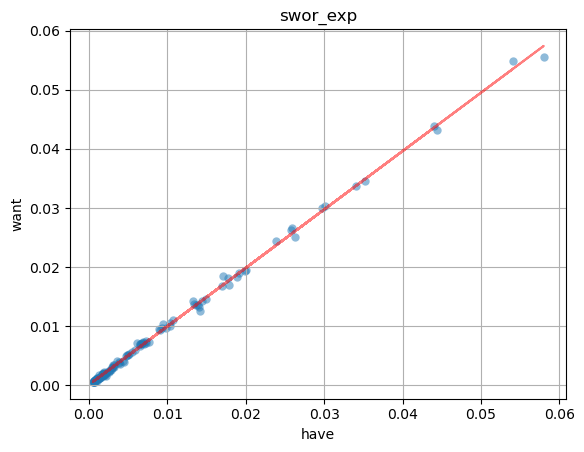


Comparison: n=120
  norms: [0.150794, 0.151176]
  pearson: 0.999236
  spearman: 0.996102
  ℓ∞: 0.00220764
  ℓ₂: 0.00472414
  same-sign: 100.00% (120/120)
  regression: [0.995 0.000] R=0.005



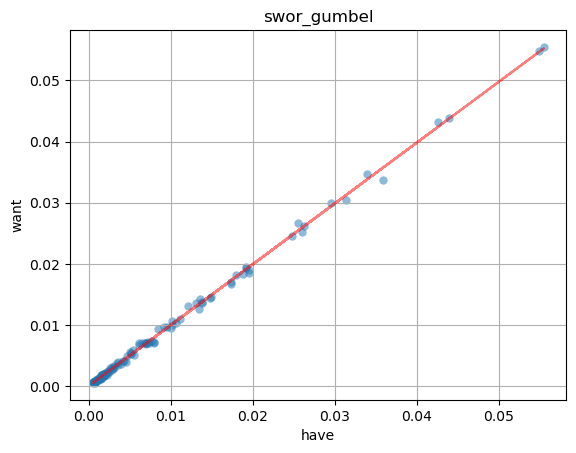


Comparison: n=120
  norms: [0.150794, 0.150319]
  pearson: 0.999361
  spearman: 0.995895
  ℓ∞: 0.00150088
  ℓ₂: 0.00432134
  same-sign: 100.00% (120/120)
  regression: [1.004 -0.000] R=0.004



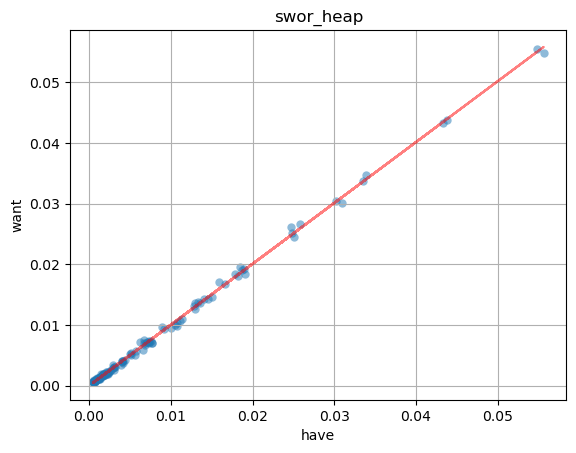


Comparison: n=120
  norms: [0.150794, 0.150936]
  pearson: 0.999362
  spearman: 0.995963
  ℓ∞: 0.00127402
  ℓ₂: 0.00429467
  same-sign: 100.00% (120/120)
  regression: [0.998 0.000] R=0.004



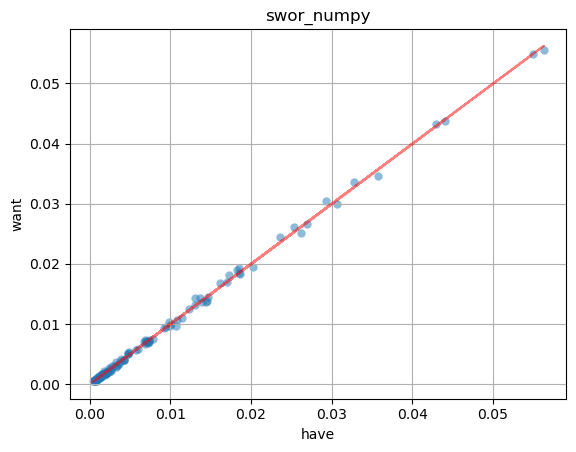

In [8]:
for name, d in sorted(D.items()):
    compare(R, d).show(title=name);

### Efficiency

In [9]:
from arsenal.timer import timers
T = timers()
R = 50
for i in range(4, 18):
    n = 2**i
    #print('n=', n, 'i=', i)
    for _ in range(R):
        v = random_dist(n)
        np.random.shuffle(methods)
        for f in methods:
            name = f.__name__
            with T[name](n = n):
                S = f(v, R = 1)
            assert S.shape == (1, n)   # some sort of sanity check
print('done')

done


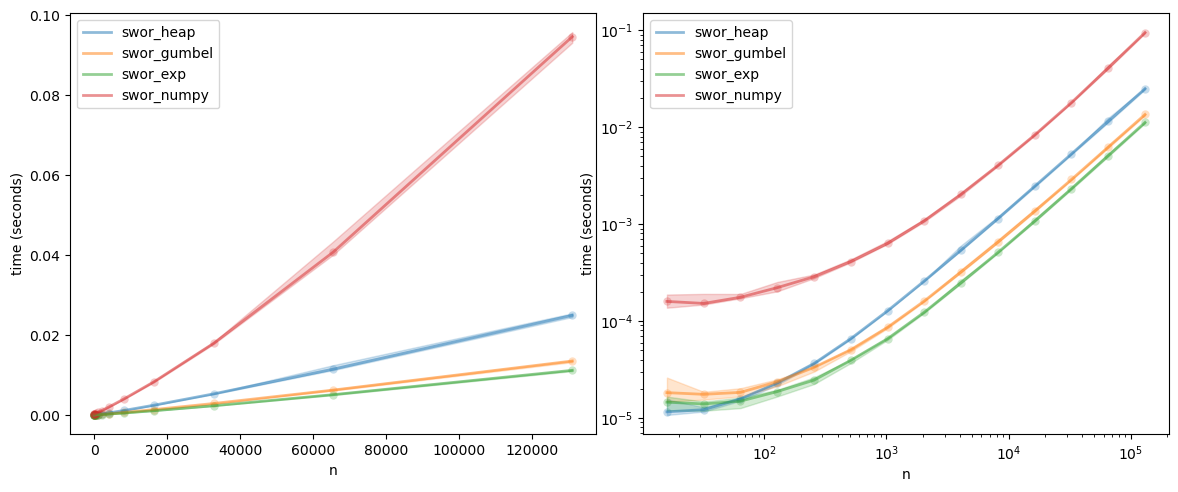

In [10]:
fig, ax = pl.subplots(ncols=2, figsize=(12, 5))
T.plot_feature('n', ax=ax[0])
fig.tight_layout()
T.plot_feature('n', ax=ax[1]); ax[1].set_yscale('log'); ax[1].set_xscale('log');

In [11]:
T.compare()

swor_exp is 1.2260x faster than swor_gumbel (p=0.00083, mean: swor_gumbel: 0.00184231, swor_exp: 0.00150269)
swor_exp is 2.2546x faster than swor_heap (p=0.00007, mean: swor_heap: 0.00338799, swor_exp: 0.00150269)
swor_exp is 8.2761x faster than swor_numpy (p=0.00000, mean: swor_numpy: 0.0124364, swor_exp: 0.00150269)


**Remarks:**

* The numpy version is not very competitive.  That's because it's uses a less efficient base algorithm that is not optimized for sampling without replacement.

* The heap-based implementation is pretty fast.  It has the best asymptotic complexity if the sample size is less then $n$.

* That said, the heap-based sampler is harder to implement than the Exp and Gumbel algorithm, and harder to vectorize, unlike Exp and Gumbel.

* The difference between the Exp and Gumbel tricks is just that the Gumbel trick takes does a few more floating-point operations.  In fact, as I pointed out in a [2014 article](http://timvieira.github.io/blog/post/2014/08/01/gumbel-max-trick-and-weighted-reservoir-sampling/), the Exp-sort and Gumbel-sort tricks produced *precisely* the same sample if we use the same random seed.

* I suspect that the performance of both the Exp and Gumbel methods could be improved with a bit of implementation effort.  For example, currently, there are some unnecessary extra temporary memory allocations.  These algorithms are also trivial to parallelize.  The real bottleneck is the random variate generation time.

**How to cite this article**: If you found this article useful, please cite it as

```
@misc{vieira2019swor-algs,
    title = {Algorithms for sampling without replacement},
    author = {Tim Vieira},
    url = "https://timvieira.github.io/blog/post/2019/09/16/algorithms-for-sampling-without-replacement/",
    year = {2019}
}
```